In [538]:
import os
import argparse
import warnings
import numpy as np
from scipy.io import wavfile
import scipy.io as sio
from hmmlearn import hmm
import librosa
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle
import math

In [539]:
class HMMTrainer(object):
    def __init__(self,model_name='GaussianHMM',n_components=1,cov_type='diag',n_iter=1000):
        self.model_name=model_name
        self.n_components= n_components
        self.cov_type=cov_type
        self.n_iter=n_iter
        self.models=[]
        
        if self.model_name=='GaussianHMM':
            self.model=hmm.GaussianHMM(n_components=self.n_components,covariance_type=self.cov_type, n_iter=self.n_iter)
        else:
            raise TypeError('Invalid model type')
            
    def train(self,X):
        np.seterr(all='ignore')
        self.models.append(self.model.fit([X]))
        print(self.model.means_.shape)
        np.set_printoptions(precision=2)
        print('model means:-  ',self.model.means_)
        for items in self.model.means_:
            plt.plot(items)
            plt.axis([0, 15, -400, 1500])
            plt.show()
            print('each mean',items)
        print('------------------')
        for items in self.model.covars_:
            plt.plot(items.diagonal())
            plt.axis([0, 15, -400, 1500])
            plt.show()
            print('each variance',items.diagonal())
        
    def get_score(self,input_data):
        return self.model.score(input_data)

In [540]:
def cross_validate(data_files, folds):
    if len(data_files) % folds != 0:
        raise ValueError(
            "invalid number of folds ({}) for the number of "
            "documents ({})".format(folds, len(data_files))
        )
    fold_size = len(data_files) 
    for split_index in range(0, len(data_files), fold_size):
        training = data_files[split_index:split_index + fold_size]
        testing =np.append(data_files[:split_index],data_files[split_index + fold_size:])
        #testing = data_files[:split_index]+data_files[split_index + fold_size:]
        yield training , testing

In [541]:
def myfunc(input_folder):
    testing=[]
    hmm_models=[]
    for dirname in os.listdir(input_folder):
        subfolder=os.path.join(input_folder,dirname)
        if not os.path.isdir(subfolder):
            continue
        label = subfolder[subfolder.rfind('/')+1:]
        data_files=[]
        for filename in[x for x in os.listdir(subfolder) if x.endswith('.wav')]:
            filepath=os.path.join(subfolder,filename)
            data_files=np.append(data_files,filepath)
        shuffle(data_files)
        #print(data_files)
        split = 0.6
        split_index = math.floor(len(data_files) * split)
        training = data_files[:split_index]
        #print(training)
        testing = np.append(testing,data_files[split_index:])
        print(label)
        hmm_model,labelnew=do_ml_training_my(training,label)
        hmm_models.append((hmm_model,labelnew))
    #print(hmm_models)
    shuffle(testing)
    print(testing)
    do_ml_testing_my(testing,hmm_models)
        #testing = file_list[split_index:]
        #print(data_files)
        #num_folds=1
        #for train_set, test_set in cross_validate(data_files, num_folds):
            #do_ml_training_my(train_set,label)
            #do_ml_testing_my(test_set)

In [542]:
def do_ml_training_my(train_set,input_folder):
    #hmm_models=[]
    X=np.empty([0,13])
    y_words=[]
    warnings.filterwarnings("ignore")
    for filename in train_set:
        data, sampling_rate = librosa.load(filename)
            #mfccs' shape would be (13,)
        print(sampling_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13).T,axis=0)
        mfccs = mfccs.astype(np.float)
        print('mfccs:----  ',mfccs)
            #adding new axis
        mfccs=mfccs[:,np.newaxis]
            #reshaping my mfccs
        mfccs=mfccs.reshape(1,13)
        if(len(X)==0):
            X= mfccs
        else:
                #appending all the mfccs of all the wav file present in each subfolder to X
            X=np.append(X,mfccs,axis=0)
            #appending labels    
        #y_words.append(label)
    hmm_trainer = HMMTrainer()
    hmm_trainer.train(X)
    newhmm=hmm_trainer
    #hmm_models.append((hmm_trainer,input_folder))
    hmm_trainer= None
    return newhmm,input_folder

In [543]:
def do_ml_testing_my(test_set,hmm_models):
    truearray=[]
    predictedarray=[]
    #print(hmm_models)
    #going into each file 
    for input_file in test_set:
        #extracting mfcc feature
        data, sampling_rate = librosa.load(input_file)
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13).T,axis=0)
        mfccs = mfccs.astype(np.float)
        mfccs=mfccs[:,np.newaxis]
        mfccs=mfccs.reshape(1,13)
        max_score=[float("-inf")]
        output_label=[float("-inf")]
        #going into every model 
        for item in hmm_models:
            #print(item)
            hmm_model,label=item
            score=hmm_model.get_score(mfccs)
            print('Score is :- ',score)
            print('Item (Model):- ',item)
            if score > max_score:
                max_score=score
                output_label=label
        print("\nTrue:",input_file[input_file.find('/')+1:input_file.rfind('/')])
        truearray.append(os.path.basename(os.path.dirname(input_file)))# 'test3'
        predictedarray.append(output_label)
        print("Predicted:",output_label)
        warnings.filterwarnings("ignore")
    print(truearray)
    print(predictedarray)
    unique_label = np.unique(truearray)
    confusionmatrix = confusion_matrix(truearray, predictedarray)
    print("Confusion matrix:\n%s" % confusionmatrix)
    #df_cm = pd.DataFrame(confusionmatrix, range(6),range(6))
    df_cm=pd.DataFrame(confusion_matrix(truearray, predictedarray, labels=unique_label), 
                   index=['true:{:}'.format(x) for x in unique_label], 
                   columns=['pred:{:}'.format(x) for x in unique_label])
    #plt.figure(figsize = (10,7))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size    

/Users/nikhil/Downloads/download (2)/wav
sadness
22050
mfccs:----   [-248.98  126.43  -12.81   67.29  -12.5    14.76  -11.31    5.44   -6.7
    5.59    6.3    -2.36    4.31]
22050
mfccs:----   [-269.58  110.76   -1.18   57.01   -2.9    30.82   12.19   13.58   -0.43
   -0.53    6.58    2.43    4.33]
22050
mfccs:----   [-187.29  131.39  -18.97   58.99  -10.18   38.39    6.36   12.57  -12.65
   -2.36    0.39   -1.75    1.99]
22050
mfccs:----   [-237.83   87.94  -23.9    57.42   -5.34   21.61   -8.28   -2.98   -3.68
   -1.35    2.39   -3.1    -5.17]
22050
mfccs:----   [-232.64  113.62  -13.59   57.18   -8.67   31.8    -3.26    7.41   -3.46
   -1.76   10.44    1.01   -1.32]
22050
mfccs:----   [-304.19   95.65   10.24   41.16   -5.64   29.08   -0.97   10.32    1.9
    3.02    7.23    1.83    5.41]
22050
mfccs:----   [ -2.94e+02   1.03e+02   2.78e+00   5.30e+01   1.33e+00   2.79e+01
  -3.40e+00   1.32e+01   8.76e-01  -3.83e+00   2.25e+00  -4.05e+00
  -8.44e-02]
22050
mfccs:----   [-214.46  11

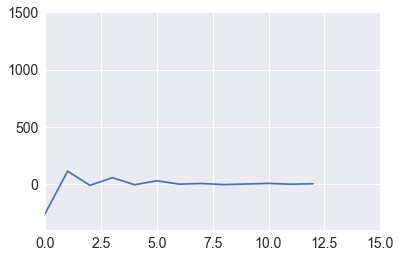

each mean [ -2.55e+02   1.12e+02  -1.18e+01   5.53e+01  -6.41e+00   2.82e+01
  -8.15e-01   4.52e+00  -5.08e+00   1.03e-01   5.26e+00  -1.52e+00
   2.29e+00]
------------------


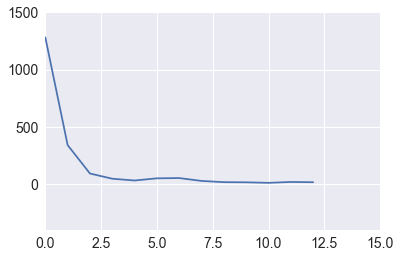

each variance [ 1281.15   339.93    91.72    46.33    30.82    49.77    52.17    27.04
    16.26    14.86    10.38    17.98    15.69]
happiness
22050
mfccs:----   [-220.07  105.54  -32.13   49.54    1.83   19.64  -21.6     0.43  -27.27
   -7.25    1.05  -17.86    4.75]
22050
mfccs:----   [-225.11  113.16  -26.16   48.48  -13.84    9.92  -19.31    6.12  -19.54
   -7.06   -1.13   -6.75    1.47]
22050
mfccs:----   [-275.12   95.68  -37.11   41.92  -16.49    8.47  -23.52   -2.34  -16.06
   -5.05   -4.06   -6.03    2.85]
22050
mfccs:----   [-281.98  117.76  -28.55   46.91    0.55    8.33  -12.42    8.51  -13.26
   -8.23    1.91  -11.44    1.2 ]
22050
mfccs:----   [-245.05   99.78  -39.19   43.77  -16.35    4.79  -21.86    1.95  -21.4
   -7.59   -1.3    -9.26    0.69]
22050
mfccs:----   [-284.83   45.54  -81.2    32.21  -36.49    1.35  -19.93   -3.43   -9.93
  -14.53   -9.    -10.85   -6.88]
22050
mfccs:----   [-264.04   86.19  -50.42   46.28  -40.83   12.65  -22.36   -4.73  -11.09
  -12.42 

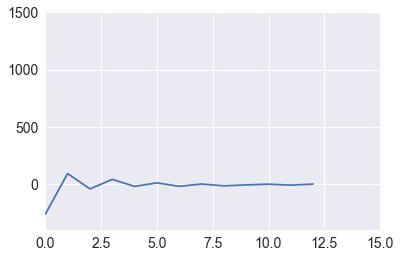

each mean [ -2.63e+02   9.16e+01  -4.28e+01   4.08e+01  -2.06e+01   9.96e+00
  -2.00e+01  -3.68e-02  -1.56e+01  -7.74e+00  -1.38e+00  -9.98e+00
  -3.47e-01]
------------------


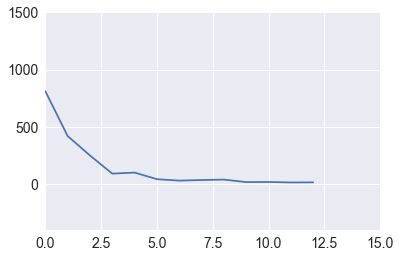

each variance [ 811.41  419.39  249.62   90.82   99.99   42.37   29.71   35.01   38.78
   16.94   17.89   13.6    14.64]
anger
22050
mfccs:----   [-261.14   91.71  -59.22   41.91  -41.34   19.63  -19.15   -2.39   -7.39
  -10.91   -0.62  -10.12   -1.48]
22050
mfccs:----   [-296.2    56.15  -85.49   36.12  -40.02    5.41  -15.35   -8.14   -6.19
  -13.19   -9.44   -6.54  -10.92]
22050
mfccs:----   [-307.23   46.85  -80.58   30.79  -46.81    5.23  -10.26  -15.09  -13.55
   -9.52   -4.71   -8.63   -8.26]
22050
mfccs:----   [-312.64   71.44  -70.74   42.59  -44.     18.97  -29.59   -4.53   -8.64
   -9.81   -1.58   -7.89    1.98]
22050
mfccs:----   [-248.78   77.08  -68.67   55.23  -33.87   14.73  -38.57    4.34  -17.69
  -18.67   -4.63  -11.82   -1.25]
22050
mfccs:----   [-250.21   61.68  -76.41   59.82  -45.82    4.22  -20.31    0.7   -14.99
  -13.    -10.15   -6.57   -3.17]
22050
mfccs:----   [-267.47   68.09  -70.88   34.89  -39.82   16.98  -30.65   -1.89  -10.36
  -10.59   -4.69   -4.6  

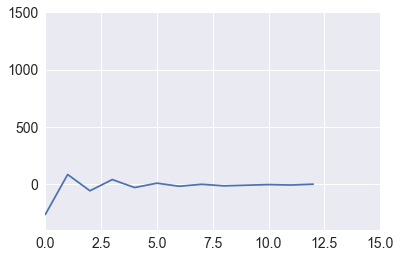

each mean [-266.24   83.36  -59.13   38.87  -30.75    7.16  -19.55   -2.34  -15.97
  -10.49   -4.9    -8.85   -1.2 ]
------------------


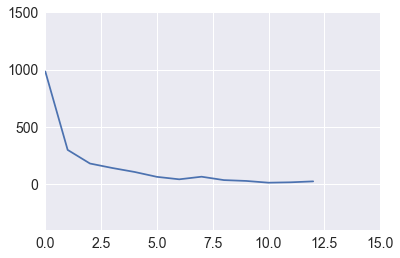

each variance [ 983.05  298.3   179.15  140.1   105.36   62.7    41.17   63.93   34.37
   26.92   11.63   15.12   23.19]
anxietyorfear
22050
mfccs:----   [-172.59  103.81  -36.58   44.46  -19.29   26.6   -14.83    4.32   -9.84
   -7.53    1.26   -5.47   -0.76]
22050
mfccs:----   [-257.3    88.09  -44.7    59.56  -11.1    39.29  -12.54   -2.71  -18.79
    6.57   16.24   -1.59   10.06]
22050
mfccs:----   [-271.09   68.4   -18.34   45.12  -18.08   24.23  -17.06    4.57   -9.4
   -3.28   -0.85  -11.41    1.83]
22050
mfccs:----   [-209.5   118.45  -45.18   71.27  -17.63   24.42  -14.81    0.76  -10.63
   -4.95  -11.35  -16.59    3.75]
22050
mfccs:----   [-257.94   91.16  -35.83   37.8   -33.93   24.41  -20.98   -4.1   -14.84
   -7.26    3.89  -10.      1.93]
22050
mfccs:----   [-255.31   68.02  -72.84   54.67  -37.47    3.75  -26.69   -5.62  -14.41
  -14.73   -4.06   -9.71   -6.54]
22050
mfccs:----   [-214.29   99.9   -57.56   41.51  -43.44   22.4   -21.41   -8.89  -10.79
  -10.4     3.13  

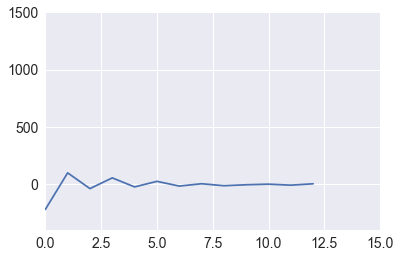

each mean [-221.98   97.56  -40.08   53.75  -25.36   23.51  -17.9     2.45  -14.78
   -6.49   -1.13  -10.03    2.17]
------------------


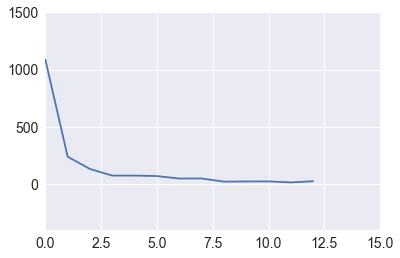

each variance [ 1087.92   239.25   131.37    73.58    73.66    69.56    47.91    48.57
    20.76    22.66    22.92    13.9     24.38]
boredom
22050
mfccs:----   [-241.62  116.92   -2.79   60.71   -7.45   20.88  -21.62   -1.39   -6.61
   -5.43    6.77   -5.5    -6.19]
22050
mfccs:----   [-224.2   135.22  -21.11   69.84    6.55   19.5    -2.81   -7.62  -24.57
   -3.99   -0.47   -8.53    5.14]
22050
mfccs:----   [-235.01  107.76  -16.02   61.18  -22.74   24.3    -7.08    1.2    -6.44
   -5.93   -4.8    -8.89   -0.37]
22050
mfccs:----   [-252.16  109.72  -47.52   55.11  -13.9    20.37  -14.67  -19.37  -10.57
    0.42    4.54  -13.11   -2.1 ]
22050
mfccs:----   [-290.16  126.63   -4.87   31.32  -13.88   16.65  -13.79    5.18  -13.03
   -5.11   -0.31   -9.57   -1.3 ]
22050
mfccs:----   [-252.74  128.33  -18.48   57.58   -8.63   25.43    7.65    6.84   -8.64
   -8.34   -0.66   -3.25   -1.95]
22050
mfccs:----   [-186.01  109.35  -22.61   59.96  -29.37   25.55  -11.81   -0.26   -7.84
   -6.47  

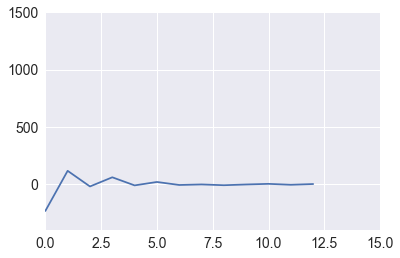

each mean [ -2.36e+02   1.15e+02  -2.13e+01   5.88e+01  -1.19e+01   1.79e+01
  -8.36e+00  -3.55e+00  -1.05e+01  -3.90e+00   1.43e+00  -6.58e+00
  -5.26e-02]
------------------


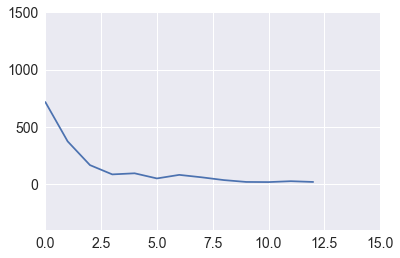

each variance [ 716.51  372.77  165.36   84.13   93.71   48.8    79.99   58.78   34.41
   18.19   16.97   24.74   18.09]
disgust
22050
mfccs:----   [-282.21   92.1   -15.47   56.94   -4.89   25.5    -6.16   -1.59   -7.11
   -4.42   -5.23   -6.33    2.18]
22050
mfccs:----   [-292.29   91.56  -14.53   46.85   -3.5    22.    -19.12   -7.93  -12.09
   -7.24    1.64   -1.58    3.14]
22050
mfccs:----   [-278.95   87.81  -20.14   47.47   -6.23    5.18  -21.86   -6.31   -8.58
   -5.05   -3.06   -2.08    2.75]
22050
mfccs:----   [-236.27   96.82  -38.22   44.57  -22.78   29.6   -20.69   -7.7   -14.35
    2.79    8.43   -5.5     7.04]
22050
mfccs:----   [-256.82   95.75  -59.57   38.94  -26.8    14.28  -21.32   -5.85  -16.14
   -4.67   -1.71   -6.5     5.65]
22050
mfccs:----   [-261.76  109.87  -11.88   40.87   -6.84   26.23  -14.84   -5.01  -14.84
    1.74    1.84   -3.65   -0.67]
22050
mfccs:----   [-216.19   92.87  -31.08   67.67   -4.27   29.82  -25.59  -10.89  -22.24
    7.29   -2.42   -8.1

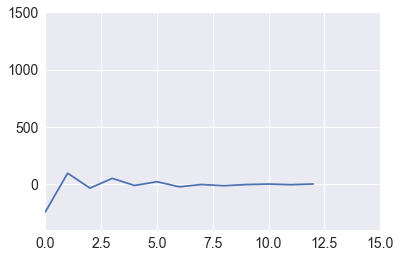

each mean [ -2.44e+02   9.46e+01  -3.55e+01   4.95e+01  -1.27e+01   2.02e+01
  -2.42e+01  -4.14e+00  -1.48e+01  -4.73e+00  -8.40e-02  -5.77e+00
   3.47e-01]
------------------


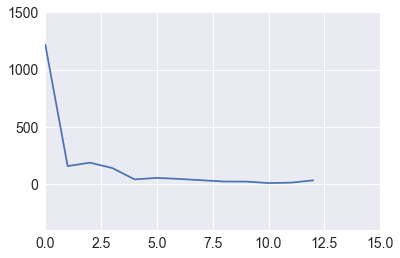

each variance [ 1217.09   156.75   186.52   139.74    40.62    53.64    44.55    32.96
    21.9     21.3      8.43    11.81    31.82]
['/Users/nikhil/Downloads/download (2)/wav/disgust/16b09Eb.wav'
 '/Users/nikhil/Downloads/download (2)/wav/anxietyorfear/16b10Aa.wav'
 '/Users/nikhil/Downloads/download (2)/wav/boredom/14a05Lb.wav'
 '/Users/nikhil/Downloads/download (2)/wav/anxietyorfear/14a05Aa.wav'
 '/Users/nikhil/Downloads/download (2)/wav/anger/09a02Wb.wav'
 '/Users/nikhil/Downloads/download (2)/wav/sadness/03b09Tc.wav'
 '/Users/nikhil/Downloads/download (2)/wav/boredom/08a05Lc.wav'
 '/Users/nikhil/Downloads/download (2)/wav/anger/16b09Wb.wav'
 '/Users/nikhil/Downloads/download (2)/wav/happiness/16b02Fd.wav'
 '/Users/nikhil/Downloads/download (2)/wav/happiness/16a01Fc.wav'
 '/Users/nikhil/Downloads/download (2)/wav/sadness/08b09Tb.wav'
 '/Users/nikhil/Downloads/download (2)/wav/disgust/15a02Ea.wav'
 '/Users/nikhil/Downloads/download (2)/wav/sadness/13a07Tc.wav'
 '/Users/nikhil/Downlo

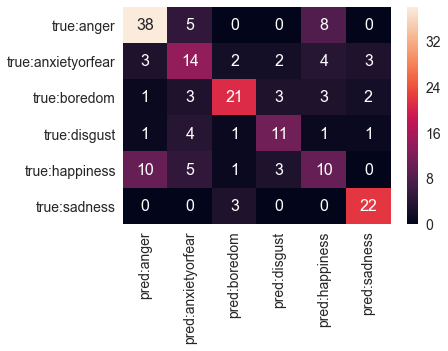

In [544]:
if __name__=='__main__':
    #input folder where you have audio database
    input_folder="/Users/nikhil/Downloads/download (2)/wav"
    print(input_folder)
    #creating empty models
    hmm_models=[]
    myfunc(input_folder)
    #going into folder
    